# Exploring the DBSCAN algorithm

Density-Based Spatial Clustering of Applications with Noise(DBSCAN) is an unsupervised machine learning model, which is robust to noise in the data.

### **Theoretical Understanding**

- **Assumption**:Clusters are regions of high density, separated by regions of low density.

**Features**

- number of clusters need not be mentioned beforehand.
- 2 parameters: 
    - *epsilon*: Radius of circle created around each data point to check density. (Calculated from K-distance graph)

    - *minPoints*: min number of points to be present in the above circle, inorder to label that point as a **core point**. (This should be *atleast 1 greater than the number of dimensions*, Generally it is twice the dimensions.)
- Scans through the entire dataset only once.
- Distance is usually calculated with Euclidean distance.

**Terms**

- *Core point*: A point that has atleast *minPoints* number of elements in the circle of radius *epsilon* around it.

- *Border Point*: if the number of elements is les than *minPoints*, then it is border point.

- *Noise* : If no other point within *epsilon* radius, it is noise.


**Reachability and Connectivity**

- Reachability - if a data point can be accessed from another data point directly or indirectly

    - Directly Density-Reachable: A point X is directly density-reachable from point Y w.r.t *epsilon*,*minPoints* if,

        - X is in the circle with radius *epsilon* where Y is the core point.
    
    - Density-Reachable : A point X is density-reachable from point Y w.r.t *epsilon*, *minPoints* if there is a chain of points p1, p2, p3, …, pn and p1=X and pn=Y such that pi+1 is directly density-reachable from pi.

- Connectivity - whether two data points belong to the same cluster or not.
    - Density-Connected: A point X is density-connected from point Y if both of them lie in the same circle with radius *epsilon* , and a  core point Z. 

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

C:\Users\jyosn\AppData\Local\Temp\ipykernel_9724\3474167874.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
X=pd.read_csv("Mall_Customers.csv")

X.drop(columns=["CustomerID"],inplace=True)
X.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [3]:
X.describe(include="all")

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200,200.000000,200.000000,200.000000
unique,2,NaN,NaN,NaN
top,Female,NaN,NaN,NaN
freq,112,NaN,NaN,NaN
mean,NaN,38.850000,60.560000,50.200000
std,NaN,13.969007,26.264721,25.823522
min,NaN,18.000000,15.000000,1.000000
25%,NaN,28.750000,41.500000,34.750000
50%,NaN,36.000000,61.500000,50.000000
75%,NaN,49.000000,78.000000,73.000000


The dataset is slightly unbalanced in terms of Gender.

In [4]:
X.isna().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

No null values

**Basic EDA**

In [5]:
x_woAge=X.drop(columns=["Gender"])

<Axes: >

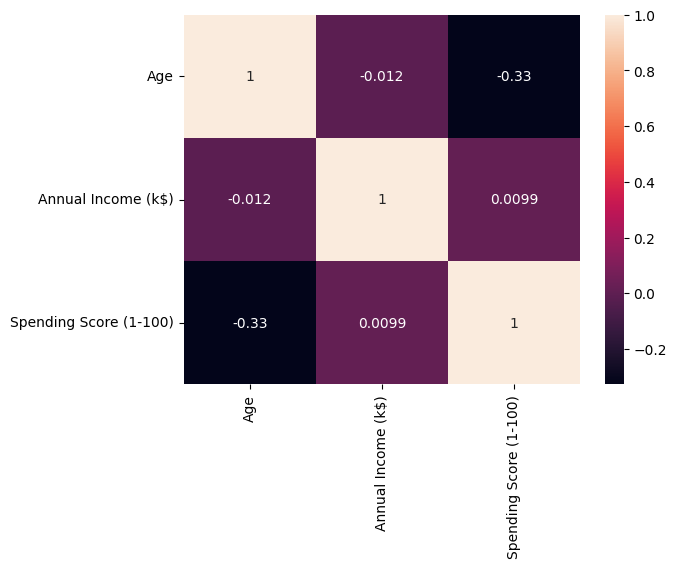

In [6]:
sns.heatmap(x_woAge.corr(),annot=True)

In [7]:
X.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

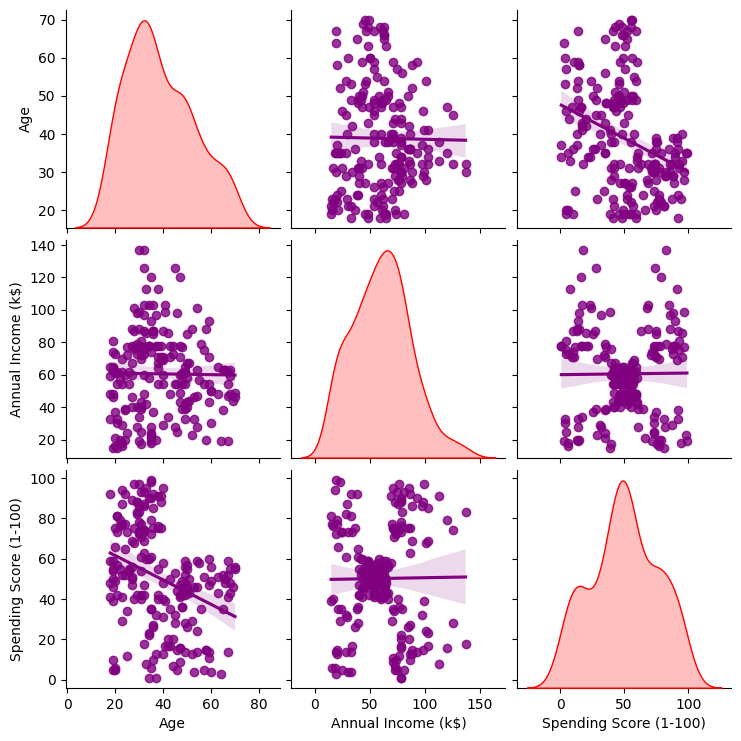

In [8]:
sns.pairplot(X,plot_kws={'color':'purple'},kind="reg",diag_kws={'color':"red"},diag_kind="kde")

In [9]:
import plotly.express as px

fig = px.parallel_coordinates(X, color="Spending Score (1-100)",
                              color_continuous_scale=px.colors.diverging.delta_r,
                              color_continuous_midpoint=2,width=600,height=400,labels={'Gender':'Gender','Age':'Age', 'Annual Income (k$)':'Annual Income' , 'Spending Score (1-100)':'Spending Score ', })
fig.show()

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets



In [11]:
X["Gender"].replace("Male",1,inplace=True)
X["Gender"].replace("Female",2,inplace=True)
X.head()

C:\Users\jyosn\AppData\Local\Temp\ipykernel_9724\2087971824.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\jyosn\AppData\Local\Temp\ipykernel_9724\2087971824.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40


In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
trf1 = ColumnTransformer([
    ('col_gender',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),[0])
],remainder='passthrough')
x_trans=trf1.fit_transform(X)
x_trans=pd.DataFrame(x_trans,columns=['Male','Female', 'Age', 'Annual Income', 'Spending Score'])
x_trans.head()

,Male,Female,Age,Annual Income,Spending Score
0,1.0,0.0,19.0,15.0,39.0
1,1.0,0.0,21.0,15.0,81.0
2,0.0,1.0,20.0,16.0,6.0
3,0.0,1.0,23.0,16.0,77.0
4,0.0,1.0,31.0,17.0,40.0


In [13]:
x_trans.columns

Index(['Male', 'Female', 'Age', 'Annual Income', 'Spending Score'], dtype='object')

In [14]:
trf2=MinMaxScaler()
x_trans[['Age', 'Annual Income', 'Spending Score']]=trf2.fit_transform(x_trans[['Age', 'Annual Income', 'Spending Score']])


In [15]:
x_trans.head()

,Male,Female,Age,Annual Income,Spending Score
0,1.0,0.0,0.019231,0.000000,0.387755
1,1.0,0.0,0.057692,0.000000,0.816327
2,0.0,1.0,0.038462,0.008197,0.051020
3,0.0,1.0,0.096154,0.008197,0.775510
4,0.0,1.0,0.250000,0.016393,0.397959


In [29]:
from sklearn.cluster import DBSCAN
import numpy as np


clustering = DBSCAN(eps=0.4, min_samples=6).fit(x_trans)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

x_trans.insert(0, 'cluster8',clustering.labels_)
# display('train2',pd.concat([fl_col(df_train).head(), 
#                             fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
# display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))
x_trans.head(10)

'model: DBSCAN(eps=0.4, min_samples=6)'

'core_sample_indices_[0:10]: [ 1  3  4  5  7  9 13 15 16 17]'

'components_[0]: [ 0.         -1.          0.         -1.          0.          0.\n  0.          1.          0.          0.05769231  0.          0.81632653]'

'labels/fit_predict[0:10]: [-1  0 -1  1  1  1 -1  1  3  1]'

,cluster8,cluster7,cluster6,cluster5,cluster4,cluster3,cluster2,cluster,Male,Female,Age,Annual Income,Spending Score
0,-1,-1,-1,-1,-1,-1,-1,0,1.0,0.0,0.019231,0.000000,0.387755
1,0,0,-1,0,-1,0,0,0,1.0,0.0,0.057692,0.000000,0.816327
2,-1,-1,-1,-1,-1,-1,-1,0,0.0,1.0,0.038462,0.008197,0.051020
3,1,1,-1,1,-1,1,1,0,0.0,1.0,0.096154,0.008197,0.775510
4,1,1,-1,1,-1,1,1,0,0.0,1.0,0.250000,0.016393,0.397959
5,1,1,-1,1,-1,1,1,0,0.0,1.0,0.076923,0.016393,0.765306
6,-1,-1,-1,-1,-1,-1,-1,0,0.0,1.0,0.326923,0.024590,0.051020
7,1,1,-1,1,-1,1,1,0,0.0,1.0,0.096154,0.024590,0.948980
8,3,-1,-1,-1,-1,-1,-1,0,1.0,0.0,0.884615,0.032787,0.020408
9,1,1,-1,1,-1,1,1,0,0.0,1.0,0.230769,0.032787,0.724490


In [30]:
x_trans['cluster8'].value_counts()

cluster8
 1    62
 2    35
-1    23
 6    15
 7    13
 0    10
 4    10
 5    10
 8    10
 3     6
 9     6
Name: count, dtype: int64

In [ ]:
cluster 6 eps=0.1
cluster 7 eps=0.2 many clusters but equal number of members


In [ ]:
clustering = DBSCAN(eps=2, min_samples=6).fit(x_trans)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

x_trans.insert(0, 'cluster2',clustering.labels_)
# display('train2',pd.concat([fl_col(df_train).head(), 
#                             fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
# display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))
x_trans.head(10)